In [1]:
import sys
import os
sys.path.append('.')

import numpy as np
import jax.numpy as jnp
import jax
from jax3dp3.model import make_scoring_function
from jax3dp3.rendering import render_planes
from jax3dp3.distributions import VonMisesFisher
from jax3dp3.utils import (
    make_centered_grid_enumeration_3d_points,
    depth_to_coords_in_camera
)
from jax3dp3.transforms_3d import transform_from_axis_angle, quaternion_to_rotation_matrix
from jax3dp3.shape import get_cube_shape, get_corner_shape
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2


In [2]:
OBJ_DEFAULT_POSE = TEMPLATE_DEFAULT_POSE = jnp.array([
    [1.0, 0.0, 0.0, -1.0],   
    [0.0, 1.0, 0.0, -1.0],   
    [0.0, 0.0, 1.0, 2.0],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)  # 0, 0, 2, 1 for center of grid

In [3]:
h, w, fx_fy, cx_cy = (
    300,
    300,
    jnp.array([200.0, 200.0]),
    jnp.array([150.0, 150.0]),
)

r = 0.1
outlier_prob = 0.01
pixel_smudge = 0

num_frames = 50

gt_poses = [
    jnp.array([
    [1.0, 0.0, 0.0, -1.0],   
    [0.0, 1.0, 0.0, -1.0],   
    [0.0, 0.0, 1.0, 2.0],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)
]
rot = R.from_euler('zyx', [1.0, -0.1, -2.0], degrees=True).as_matrix()
delta_pose =     jnp.array([
    [1.0, 0.0, 0.0, 0.15],   
    [0.0, 1.0, 0.0, 0.05],   
    [0.0, 0.0, 1.0, 0.02],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)
delta_pose = delta_pose.at[:3,:3].set(jnp.array(rot))

for t in range(num_frames):
    gt_poses.append(gt_poses[-1].dot(delta_pose))
gt_poses = jnp.stack(gt_poses)
print("gt_poses.shape", gt_poses.shape)

shape = get_cube_shape(0.5)


gt_poses.shape (51, 4, 4)


In [4]:
# # r_euler_rot = jax.jit(functools.partial(R.from_euler, 'zyx'))  
# # %timeit r_euler_rot(np.array([1.0, -0.1, -2.0]), degrees=True).as_matrix()   # doesnt work due to TracerArrayConversionError

# # test vmapping over range

# def toy_abc(a, b, c):
#     return jnp.array([a, b, c])

# sample_range = jnp.array([a for a in range(1, 4)])  
# mapped_toy = jax.jit(jax.vmap(jax.vmap(jax.vmap(toy_abc, in_axes=(0, None, None)), in_axes=(None, 0, None)), in_axes=(None, None, 0)))
# mapped_toy(sample_range, sample_range, sample_range).shape

In [6]:
from jax3dp3.transforms_3d import geodesicHopf_select_axis, fibonacci_sphere


In [30]:
unit_sphere_directions = fibonacci_sphere(300)
geodesicHopf_select_axis_vmap = jax.vmap(jax.vmap(geodesicHopf_select_axis, in_axes=(0,None)), in_axes=(None,0))
rotation_proposals = geodesicHopf_select_axis_vmap(unit_sphere_directions, jnp.arange(0, 2*jnp.pi, 0.25)).reshape(-1, 4, 4)
rotation_proposals.shape

(7800, 4, 4)

In [31]:
render_planes_jit = jax.jit(lambda p: render_planes(p,shape,h,w,fx_fy,cx_cy))
render_planes_parallel_jit = jax.jit(jax.vmap(lambda p: render_planes(p,shape,h,w,fx_fy,cx_cy)))
gt_images = render_planes_parallel_jit(gt_poses)
# print("gt_images.shape", gt_images.shape)
# print((gt_images[0,:,:,-1] > 0 ).sum())

key = jax.random.PRNGKey(3)
scorer = make_scoring_function(shape, h, w, fx_fy, cx_cy ,r, outlier_prob)
# score = scorer(key, gt_poses[0,:,:], gt_images[0,:,:,:])
# score = scorer(gt_poses[0,:,:], gt_images[0,:,:,:])

scorer_parallel = jax.vmap(scorer, in_axes = (0, None))

# print("score", score)

In [10]:
def grayscale(arr, max_depth=10.0):
    return (np.array(arr) / max_depth * 255.0).astype('uint8')

In [11]:
# TODO
"""
# Define a corner rendering function (like get cube shape) so that we can reliably render from any position
# (get a coordinate image for the template)

# initialize template center at the center of the ORB point
# WITHIN patch follow icp protocols (see icp.jl: get distances to all neighbors, take argmin, get rotation via svd)
"""

# Get a generic corner shape
corner_shape = get_corner_shape(0.15)
# render_planes_jit = jax.jit(lambda p: render_planes(p,shape,h,w,fx_fy,cx_cy))
render_corner_jit = jax.jit(lambda p, crnr_shape: render_planes(p, crnr_shape, h, w, fx_fy, cx_cy))
corner_template = render_corner_jit(TEMPLATE_DEFAULT_POSE, corner_shape) 

# plt.imshow(corner_template[:, :, 2]); plt.show()  # visualize shape

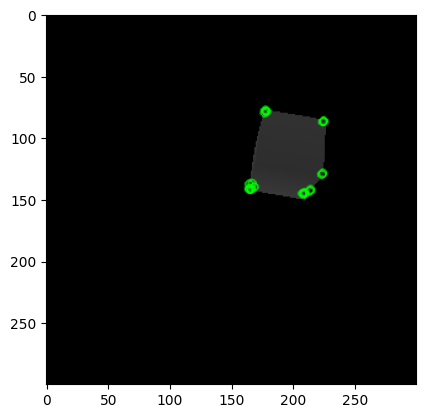

223 129


In [12]:
# Get observed frame, compute keypoints, and take one for experiment

test_gt_images = []

test_frame_idx = 10
observed = gt_images[test_frame_idx, :, :, :]
test_gt_images.append(observed); test_gt_images = jnp.stack(test_gt_images)
observed_viz = grayscale(observed)
observed_depth = observed[:, :, 2]
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints / descriptors with ORB
kp, des = orb.detectAndCompute(observed_viz,None)
observed_depth_kp = cv2.drawKeypoints(observed_viz[:, :, 2], kp, None, color=(0,255,0), flags=0)  # just for viz
plt.imshow(observed_depth_kp), plt.show()


sample_keypoint = kp[4].pt  # example
t_col, t_row = sample_keypoint
t_col, t_row = int(t_col), int(t_row); print(t_col, t_row)
obs_x, obs_y, obs_z = observed[t_row, t_col, :3]

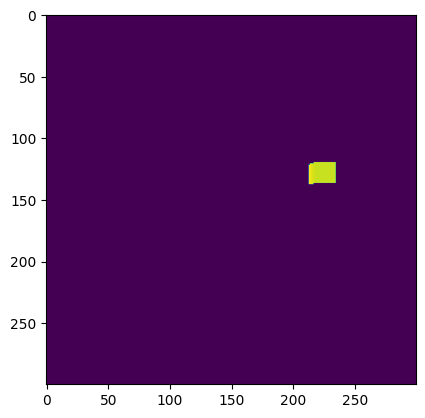

In [13]:
# move the corner template to the desired position (with an initial orientation)

dx, dy, dz =  (observed[t_row, t_col, :3] - TEMPLATE_DEFAULT_POSE[:3,-1])
# dx, dy, dz = 1.5, 0, 0 
tm = jnp.array([
    [1.0, 0.0, 0.0, dx],   
    [0.0, 1.0, 0.0, dy],   
    [0.0, 0.0, 1.0, dz],   
    [0.0, 0.0, 0.0, 1.0],   
    ]
)  # full transition matrix

gx, gy, gz = observed[t_row, t_col, :3]
translation_proposal = jnp.array([
    [0.0, 0.0, 0.0, gx],   
    [0.0, 0.0, 0.0, gy],   
    [0.0, 0.0, 0.0, gz],   
    [0.0, 0.0, 0.0, 0.0],   
    ]
)  # translation-only delta matrix


moved_corner_template = render_corner_jit(tm @ OBJ_DEFAULT_POSE, corner_shape)
plt.imshow(grayscale(moved_corner_template[:, :, 2])); plt.show()  # visualize shape

In [32]:
NUM_BATCHES = rotation_proposals.shape[0] // 300
rotation_proposals_batches = jnp.array(jnp.split(rotation_proposals, NUM_BATCHES))

def inference_frame(gt_image):  # scan over batches for single image
    def enum_infer_batch_scan(carry, rotation_proposals_batch):  # use global translation proposal/gt_test_images
        # score over the selected rotation proposals
        proposals = rotation_proposals_batch + translation_proposal
        weights_new = scorer_parallel(proposals, gt_image)
        x, x_weight = proposals[jnp.argmax(weights_new)], jnp.max(weights_new)

        # prev_x, prev_weight = carry
        new_x, new_weight = jax.lax.cond(carry[-1] > x_weight, lambda: carry, lambda: (x, x_weight))

        return (new_x, new_weight), None  # return highest weight pose proposal encountered so far
    best_prop, _ = jax.lax.scan(enum_infer_batch_scan, (jnp.empty((4,4)), jnp.NINF), rotation_proposals_batches)
    return best_prop[0]

inference_frame_jit = jax.jit(inference_frame)
# best_pos = inference_frame(test_gt_images[0])

inference_frames = jax.vmap(inference_frame_jit, in_axes=(0)) # vmap over images
inference_frames_jit = jax.jit(inference_frames)



In [34]:
all_best_poses = inference_frames_jit(test_gt_images)

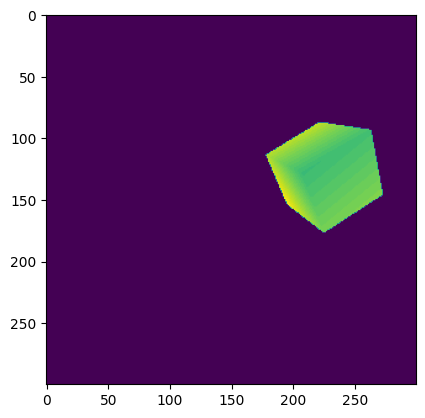

In [35]:
final_corner_template = render_planes_jit(all_best_poses[0])
plt.imshow(grayscale(final_corner_template[:, :, 2])); plt.show()  # visualize shape

In [ ]:
# def inference_batch(gt_images):
#     return jax.lax.scan(enum_infer_partial, )

In [ ]:
# save preliminary results in gif
cm = plt.get_cmap('turbo')

max_depth = 10.0
images = []
middle_width = 50
for i in range(gt_images.shape[0]):
    dst = Image.new(
        "RGBA", (2 * w + middle_width, h)
    )
    observed_image_pil = Image.fromarray(
        (cm(np.array(gt_images[i,:, :, 2]) / max_depth) * 255.0).astype(np.int8), mode="RGBA"
    )

    dst.paste(
        observed_image_pil,
        (0, 0),
    )

    ######

    pose = inferred_poses[i]
    rendered_image = render_planes_jit(pose)
    # rendered_image = render_corner_jit(pose, corner_shape)
    rendered_image_pil = Image.fromarray(
        (cm(np.array(rendered_image[:, :, 2]) / max_depth) * 255.0).astype(np.int8), mode="RGBA"
    )

    # with keypoits
    # rendered_frame = np.array(rendered_image[:, :, 2] / max_depth * 255.0).astype('uint8')
    # rendered_image_pil = Image.fromarray(
    #     rendered_frame, mode="RGBA"
    # )

    # orb = cv2.ORB_create(nfeatures=10)
    # # find the keypoints with ORB
    # kp = orb.detect(rendered_frame,None)
    # # compute the descriptors with ORB
    # kp, des = orb.compute(rendered_frame, kp)
    # draw only keypoints location,not size and orientation
    # rendered_image_pil = Image.fromarray(cv2.drawKeypoints(rendered_frame, kp, None, color=(0,255,0), flags=0))
    dst.paste(
        rendered_image_pil,
        (w + middle_width, 0),
    )
    images.append(dst)



images[0].save(
    fp="kerm_out.gif",
    format="GIF",
    append_images=images,
    save_all=True,
    duration=200,
    loop=0,
)